In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
import re
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import PrecisionRecallDisplay

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
def PCA_Model(n_comp, df, y_col, X):
    
    pca = PCA(n_components=n_comp)
    principalComponents = pca.fit_transform(X)

    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC'+str(i) for i in range(n_comp)])
    final_Df = pd.concat([principalDf, df[[y_col]].reset_index(drop=True)], axis=1)
    
    explained_var = pca.explained_variance_ratio_
    cumulative_explained = np.cumsum(pca.explained_variance_ratio_)

    print('Explained variance:\n', [round(i, 3) for i in explained_var])

    PC_values = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(12,4))
    plt.suptitle('Scree Plot')
    plt.subplot(1,2,1)
    plt.plot(PC_values, explained_var, 'o-', linewidth=2, color='blue')
    plt.ylim((0,1))
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.subplot(1,2,2)
    plt.plot(PC_values, cumulative_explained, 'o-', linewidth=2, color='red')
    plt.ylim((0,1))
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (CUMULATIVE)')
    plt.show()
    
    sns.scatterplot(
        x="PC1", y="PC2",
        hue=y_col,
        palette=sns.color_palette("hls", 2),
        data=final_Df,
        legend="full",
    )

In [5]:
def Feature_Importance(model, df, figsize=(7,5)):
    importances = pd.DataFrame(data={'Attribute': df.columns,'Importance': model.coef_[0]})
    plt.figure(figsize=figsize)
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
    plt.title('Feature importances obtained from coefficients')
    plt.xticks(rotation=80)
    plt.show()

# Using Recent 10 Games Average

In [6]:
recent_df = pd.read_csv('teams_recent_stats.csv', index_col = 0)

In [7]:
recent_df

,SEASON_ID,GAME_ID,GAME_DATE,Team_Home,Team_Away,Home_Team_Won,H_Recent_OffRtg,H_Recent_DefRtg,H_Recent_NetRtg,H_Recent_AST%,...,A_Recent_PIE,A_Recent_FGM,A_Recent_FGA,A_Recent_FG_PCT,A_Recent_FG3M,A_Recent_FG3A,A_Recent_FG3_PCT,A_Recent_FTM,A_Recent_FTA,A_Recent_FT_PCT
0,22022,22200315,11/30/2022,BKN,WAS,1,113.81,113.54,0.28,64.75,...,53.13,42.4,88.8,0.4786,13.5,35.6,0.3806,16.1,20.9,0.7661
1,22022,22200313,11/30/2022,ORL,ATL,0,108.54,115.23,-6.67,54.99,...,48.25,40.1,88.5,0.4543,9.2,29.3,0.3128,20.3,24.2,0.8413
2,22022,22200320,11/30/2022,DEN,HOU,1,116.59,115.96,0.65,62.85,...,50.01,39.2,84.5,0.4641,13.1,35.9,0.3599,21.1,26.8,0.7824
3,22022,22200321,11/30/2022,PHX,CHI,1,117.49,113.10,4.39,59.95,...,49.46,42.7,88.4,0.4844,10.1,29.2,0.3345,16.3,20.2,0.8044
4,22022,22200316,11/30/2022,NYK,MIL,0,117.43,116.49,0.93,56.85,...,48.97,41.2,89.4,0.4628,12.9,35.8,0.3591,16.8,24.0,0.6986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,22015,21500014,10/28/2015,PHX,DAL,0,102.93,104.60,-1.68,57.25,...,50.47,34.4,80.1,0.4308,10.2,31.0,0.3289,16.9,21.6,0.7912
8609,22015,21500005,10/28/2015,BOS,PHI,1,105.18,106.58,-1.40,59.61,...,42.73,36.1,88.5,0.4101,13.4,37.5,0.3606,15.2,21.4,0.7400
8610,22015,21500003,10/27/2015,GSW,NOP,1,110.03,102.76,7.25,64.63,...,47.88,38.3,82.7,0.4652,9.3,22.8,0.4085,16.4,21.7,0.7631
8611,22015,21500002,10/27/2015,CHI,CLE,1,108.90,108.92,-0.01,62.76,...,52.74,38.8,84.9,0.4593,13.1,33.1,0.3965,16.8,21.8,0.7572


In [8]:
X = recent_df.iloc[:, 6:]
y = recent_df['Home_Team_Won']

x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

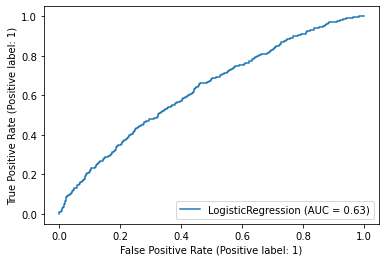

In [9]:
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

- Baseline AUC = 0.63, comparing correlation and statistical significance below:

Explained variance:
 [0.206, 0.173, 0.138, 0.06, 0.058]


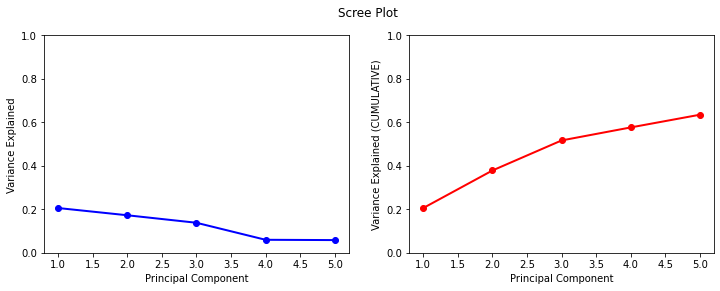

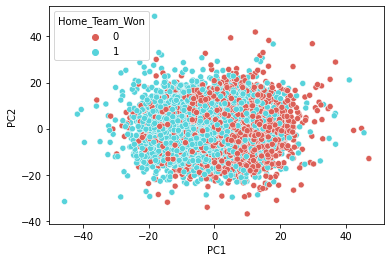

In [10]:
PCA_Model(n_comp=5, df=recent_df, y_col='Home_Team_Won', X=X)

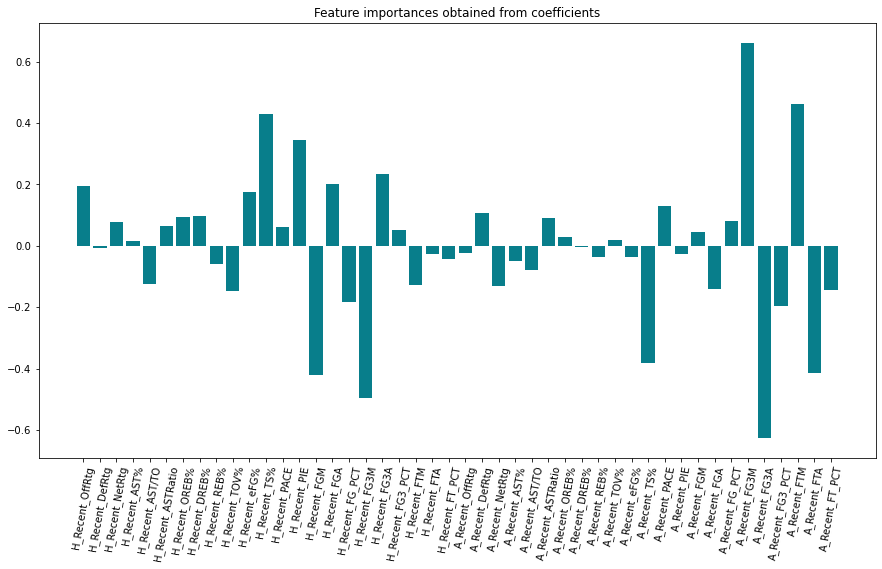

In [11]:
Feature_Importance(model=logRe, df=X, figsize=(15,8))

# Drop highly correlated variables & Rerun

In [12]:
from sklearn import metrics
var = {}; auc = {}

# Bivariate Analysis
for i,v in enumerate(pd.DataFrame(X_train).columns):
    var[i] = v
    auc[i] = metrics.roc_auc_score(y_train, pd.DataFrame(X_train)[v].fillna(0))
bivariate_auc = pd.DataFrame({'feature':var,'auc':auc}).set_index('feature')

corr_matrix = pd.DataFrame(X_train).corr()

threshold_corr = 0.7
lst_drop = []

for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if (abs(corr_matrix.loc[i,j]) >= threshold_corr) & (i!=j):
            if bivariate_auc.loc[i][0]>=bivariate_auc.loc[j][0]:
                lst_drop.append(j)
                       
lst_drop = list(set(lst_drop))
lst_keep = list(set(corr_matrix.index.tolist()) - set(lst_drop))         
print('Drop:', len(lst_drop))
print('Keep:', len(lst_keep))

Drop: 18
Keep: 28


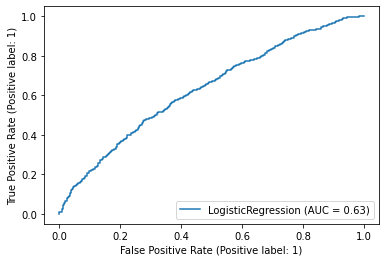

In [13]:
X = X.iloc[:, lst_keep]
x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

Explained variance:
 [0.208, 0.189, 0.109, 0.08, 0.073]


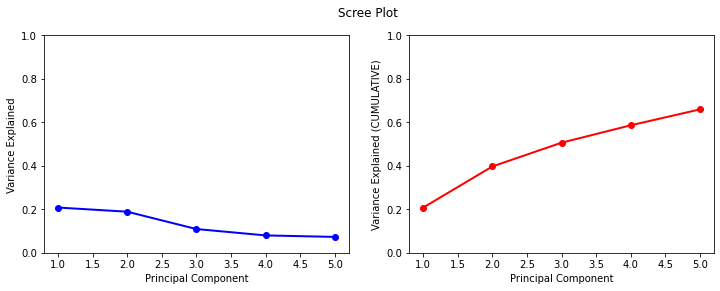

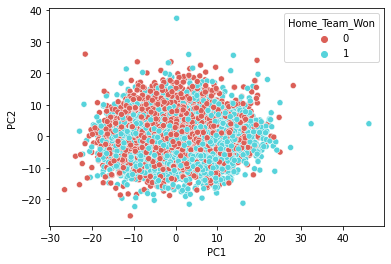

In [14]:
PCA_Model(n_comp=5, df=recent_df, y_col='Home_Team_Won', X=X)

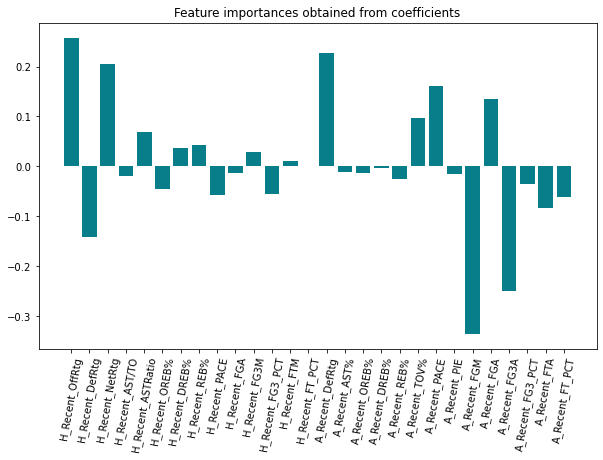

In [15]:
Feature_Importance(logRe, X, (10,6))

# Repeat, set new correlation threshold

In [16]:
from sklearn import metrics
var = {}; auc = {}

# Bivariate Analysis
for i,v in enumerate(pd.DataFrame(X_train).columns):
    var[i] = v
    auc[i] = metrics.roc_auc_score(y_train, pd.DataFrame(X_train)[v].fillna(0))
bivariate_auc = pd.DataFrame({'feature':var,'auc':auc}).set_index('feature')

corr_matrix = pd.DataFrame(X_train).corr()

threshold_corr = 0.5
lst_drop = []

for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if (abs(corr_matrix.loc[i,j]) >= threshold_corr) & (i!=j):
            if bivariate_auc.loc[i][0]>=bivariate_auc.loc[j][0]:
                lst_drop.append(j)
                       
lst_drop = list(set(lst_drop))
lst_keep = list(set(corr_matrix.index.tolist()) - set(lst_drop))         
print('Drop:', len(lst_drop))
print('Keep:', len(lst_keep))

Drop: 13
Keep: 15


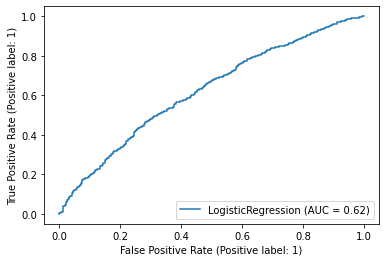

In [17]:
X = X.iloc[:, lst_keep]
x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

In [18]:
recent_cols = X.columns.tolist() #Variables in recent performance that are significant
print(recent_cols)

['H_Recent_NetRtg', 'H_Recent_REB%', 'H_Recent_FGA', 'H_Recent_FTM', 'H_Recent_FT_PCT', 'A_Recent_DefRtg', 'A_Recent_AST%', 'A_Recent_OREB%', 'A_Recent_DREB%', 'A_Recent_TOV%', 'A_Recent_PACE', 'A_Recent_FG3A', 'A_Recent_FG3_PCT', 'A_Recent_FTA', 'A_Recent_FT_PCT']


Explained variance:
 [0.232, 0.225, 0.14, 0.105, 0.064]


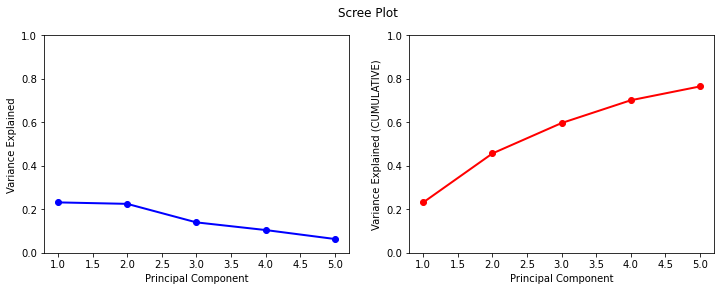

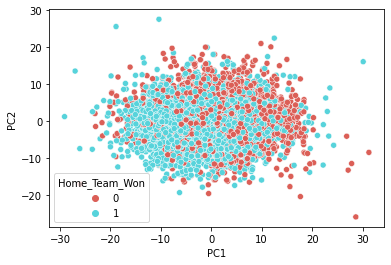

In [19]:
PCA_Model(n_comp=5, df=recent_df, y_col='Home_Team_Won', X=X)

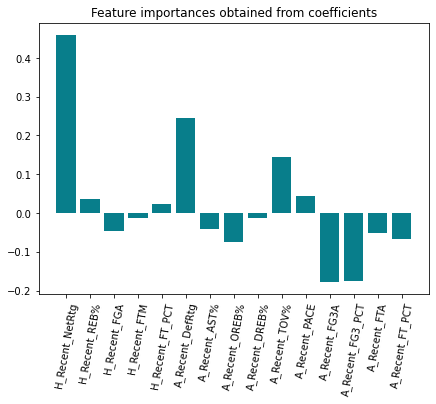

In [20]:
Feature_Importance(logRe, X)

# Elo Ratings Function Block

In [21]:
nba_elo = pd.read_csv('nba_elo.csv')
nba_elo.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'carm-elo1_pre', 'carm-elo2_pre', 'carm-elo_prob1', 'carm-elo_prob2',
       'carm-elo1_post', 'carm-elo2_post', 'raptor1_pre', 'raptor2_pre',
       'raptor_prob1', 'raptor_prob2', 'score1', 'score2', 'quality',
       'importance', 'total_rating'],
      dtype='object')

In [22]:
elo = nba_elo[nba_elo['season'] >= 2015][['date', 'team1', 'team2', 'elo1_pre', 'elo2_pre',
                                  'elo1_post', 'elo2_post']]
elo_teams = elo['team1'].unique().tolist()

def update_name(x):
    if x == 'PHO':
        return 'PHI'
    elif x == 'CHO':
        return 'CHA'
    elif x == 'BRK':
        return 'BKN'
    else:
        return x
    
elo['Team_Home'] = elo['team1'].map(lambda x: update_name(x))
elo['Team_Away'] = elo['team2'].map(lambda x: update_name(x))

from datetime import datetime
elo.rename(columns = {'date': 'GAME_DATE'}, inplace = True)
elo['GAME_DATE'] = elo['GAME_DATE'].map(lambda x:
                                              pd.to_datetime(x).strftime('%m/%d/%Y'))
elo.drop(columns = {'team1', 'team2'}, inplace = True)

elo_df = pd.merge(recent_df, elo, on = ['GAME_DATE', 'Team_Home', 'Team_Away'], how = 'inner')

In [23]:
# elo_df = pd.merge(recent_df, team_elo, on = ['GAME_ID', 'Team_Home', 'Team_Away'])
elo_cols = elo_df.columns[elo_df.columns.str.contains('pre')].tolist()
cols = elo_cols + recent_cols
print(cols)

['elo1_pre', 'elo2_pre', 'H_Recent_NetRtg', 'H_Recent_REB%', 'H_Recent_FGA', 'H_Recent_FTM', 'H_Recent_FT_PCT', 'A_Recent_DefRtg', 'A_Recent_AST%', 'A_Recent_OREB%', 'A_Recent_DREB%', 'A_Recent_TOV%', 'A_Recent_PACE', 'A_Recent_FG3A', 'A_Recent_FG3_PCT', 'A_Recent_FTA', 'A_Recent_FT_PCT']


In [24]:
X = elo_df.loc[:, cols]
y = elo_df['Home_Team_Won']

x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

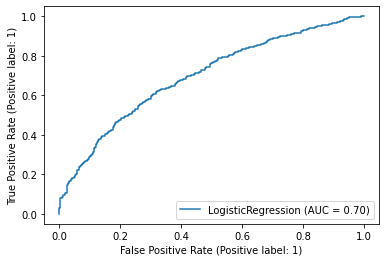

In [25]:
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

- Combining ELO and recent performance --> AUC = 0.69

Explained variance:
 [0.511, 0.481, 0.002, 0.001, 0.001]


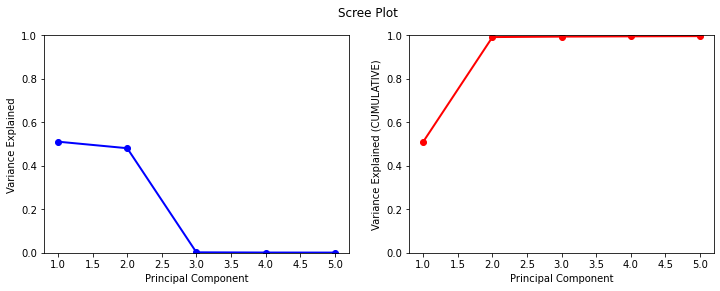

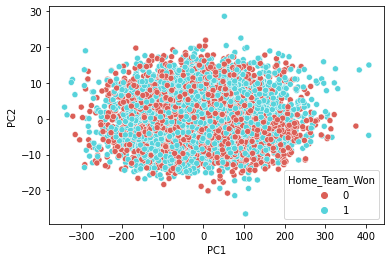

In [26]:
PCA_Model(5, elo_df, y_col='Home_Team_Won', X=X)

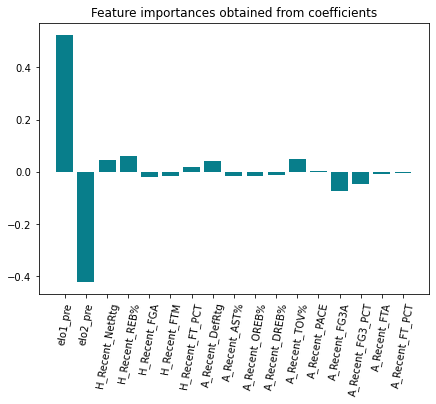

In [27]:
Feature_Importance(logRe, X)

# Player Models

In [28]:
player = pd.read_csv('player_base_advance_game.csv')#, index_col = 0)

player['WIN'] = np.where(player['W/L'] == 'W', 1, 0)
player = player.drop(columns=['W/L','MATCH_UP'])
player = player.drop_duplicates().dropna()

# every player plus 1 minute
player['MIN'] = player.MIN.apply(lambda x: x+1)

In [29]:
import datetime
player['YM'] = player['GAME_DATE'].map(lambda x:(pd.to_datetime(x).to_period('M').strftime('%Y/%m')))

In [30]:
player2 = player.copy()

In [31]:
player2.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM', 'PLAYER', 'MIN', 'GAME_DATE', 'PTS',
       'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'OffRtg',
       'DefRtg', 'NetRtg', 'AST%', 'AST/TO', 'AST_Ratio', 'OREB%', 'DREB%',
       'REB%', 'TO_Ratio', 'eFG%', 'TS%', 'USG%', 'PACE', 'PIE', 'WIN', 'YM'],
      dtype='object')

# Player Stat Engineered: Game Score, PER, PPP

In [32]:
#PPP
player2['PPP'] = (player2.PTS) / (player2.FGA + 0.44 * player2.FTA - player2.OREB + player2.TOV)

In [33]:
#Game Score
player2['GAME_SCORE'] = player2.PTS + \
    0.4 * player2.FGM - 0.7 * player2.FGA - \
    0.4 * (player2.FTA - player2.FTM) + \
    0.7 * player2.OREB + 0.3 * player2.DREB + player2.STL + \
    0.7 * player2.AST + 0.7 * player2.BLK - 0.4 * player2.PF - player2.TOV

In [34]:
#PER
player2['PER'] = (player2.FGM * 85.91 + player2.STL * 53.897 + player2['3PM'] * 51.757 + \
    player2['FTM'] * 46.845 + player2.BLK * 39.19 + player2.OREB * 39.19 + \
    player2.AST * 34.677 + player2.DREB * 14.70 - player2.PF * 17.174 - (player2.FTA - player2.FTM) * 20.091 -\
    (player2.FGA - player2.FGM)*39.19 - player2.TOV * 53.897) * (1/player2.MIN)

In [35]:
wanted_cols = ['GAME_ID','GAME_DATE','YM','TEAM','PLAYER','MIN','PIE','+/-','TS%','GAME_SCORE','PER','PPP','WIN']
df = player2[wanted_cols].sort_values(by = ['YM', 'PLAYER', 'TEAM'], ascending = False)
df.fillna(0, inplace = True)

#First Find Monthly Player Minutes
player_month_min = df.groupby(['TEAM', 'YM', 'PLAYER'])[['MIN', 'WIN']].sum().reset_index().rename(columns = {'MIN':'P_MONTH_MINS', 'WIN':'P_MONTH_WINS'})
df = pd.merge(df, player_month_min, on = ['YM', 'PLAYER', 'TEAM'])

#Monthly Team Minutes
team_month_min = df.groupby(['YM', 'TEAM'])[['MIN']].sum().reset_index().rename(columns = {'MIN':'T_MONTH_MINS'})
df = pd.merge(df, team_month_min, on = ['YM', 'TEAM'])

In [36]:
win = df.groupby(['TEAM', 'YM','GAME_ID'])[['WIN']].sum().reset_index()
total_per_month = win.groupby(['TEAM','YM'])[['WIN']].count().reset_index()

#Label Games Won
win['T_GAMES_WON'] = np.where(win.WIN == 0, 0, 1)

win = win.groupby(['TEAM','YM'])[['T_GAMES_WON']].sum().reset_index()

#Compute Team Winning%
win = win.merge(total_per_month, on=['TEAM','YM'],how='inner').rename(columns={'WIN':'T_GAMES_MONTH'})
win['TEAM_WIN%'] = win['T_GAMES_WON']/win['T_GAMES_MONTH']

df_2 = pd.merge(df, win, on = ['TEAM', 'YM'], how = 'left')

cols_to_shift = ['P_MONTH_MINS','T_MONTH_MINS','P_MONTH_WINS','T_GAMES_WON']
df_3 = df_2[['GAME_ID','YM','TEAM','PLAYER'] + cols_to_shift]

In [37]:
#Shift Minutes
df_tmp = df_3.groupby(['PLAYER','YM'])[cols_to_shift].shift(1)
df_tmp = df_tmp.add_suffix('_SHIFT')
df_shifted = pd.concat([df_3.iloc[:, :4], df_tmp], axis = 1)

In [38]:
#Find Shifted Minutes for Weighting
df_4 = pd.merge(df_2, df_shifted, on = ['GAME_ID','PLAYER','TEAM','YM'], how='left').drop(columns = cols_to_shift)
#df_4 = df_4.dropna()
df_4['w_MIN'] = df_4['P_MONTH_MINS_SHIFT'] / df_4['T_MONTH_MINS_SHIFT']
df_4['PLAYER_WIN%'] = df_4['P_MONTH_WINS_SHIFT'] / df_4['T_GAMES_WON_SHIFT']

cols = df_4.columns[~df_4.columns.str.contains('SHIFT')]
df_5 = df_4.loc[:, cols]
#df5[['w_MIN','player_win_perc']] = df5[['w_MIN','player_win_perc']].fillna(0)
df_5

,GAME_ID,GAME_DATE,YM,TEAM,PLAYER,MIN,PIE,+/-,TS%,GAME_SCORE,PER,PPP,WIN,T_GAMES_MONTH,TEAM_WIN%,w_MIN,PLAYER_WIN%
0,22200318,11/30/22,2022/11,NOP,Zion Williamson,38,23.9,19,81.4,34.4,45.067605,1.550752,1,15,0.600000,NaN,NaN
1,22200304,11/28/22,2022/11,NOP,Zion Williamson,36,20.0,19,62.4,21.5,29.607722,1.125245,1,15,0.600000,0.110036,0.777778
2,22200279,11/25/22,2022/11,NOP,Zion Williamson,31,9.7,-32,54.3,11.5,18.038258,1.086957,0,15,0.600000,0.110036,0.777778
3,22200269,11/23/22,2022/11,NOP,Zion Williamson,28,32.5,20,74.3,30.3,54.401643,1.727862,1,15,0.600000,0.110036,0.777778
4,22200253,11/21/22,2022/11,NOP,Zion Williamson,24,7.4,28,51.4,5.9,11.023083,0.836431,1,15,0.600000,0.110036,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173610,21500004,10/28/15,2015/10,WAS,Drew Gooden,21,3.8,-14,25.0,3.5,8.671238,1.500000,1,3,0.666667,0.064336,0.500000
173611,21500034,10/31/15,2015/10,WAS,DeJuan Blair,5,-300.0,3,0.0,-2.8,-28.428400,0.000000,0,3,0.666667,NaN,NaN
173612,21500034,10/31/15,2015/10,WAS,Bradley Beal,38,11.4,-9,51.6,14.1,17.316500,0.992366,0,3,0.666667,NaN,NaN
173613,21500027,10/30/15,2015/10,WAS,Bradley Beal,31,12.9,9,73.2,14.4,22.430806,1.194853,1,3,0.666667,0.151049,1.000000


In [39]:
#Value Weight Individual Ratings By Minutes Per Month
cols = df.columns[6:-1]

month_lag_cols = []
def get_stats(df):
    for stat in cols:
        stat_min = '{}_MIN'.format(stat)
        df[stat_min] = df[stat] * df['MIN']
        df_2 = (df.groupby(['YM', 'PLAYER'])[[stat_min]].sum().rename(columns = {stat_min:'{}_M'.format(stat)})/\
                                                          df.groupby(['YM', 'PLAYER'])\
                                                          [['MIN']].sum().rename(columns = {'MIN':'{}_M'.format(stat)})).reset_index()
        # Shift value weighted monthly stats 
        df_2['{}_1'.format(stat)] = df_2.groupby(['PLAYER'])['{}_M'.format(stat)].shift(1)
        df = pd.merge(df, df_2, on = ['YM', 'PLAYER'], how = 'left')
        month_lag_cols.append('{}_1'.format(stat))
    return df

In [40]:
stats_df = get_stats(df)

In [41]:
wanted_cols = df.columns[:5].values.tolist() + month_lag_cols 
stats_df = stats_df[wanted_cols].dropna()

In [42]:
print(month_lag_cols)

['PIE_1', '+/-_1', 'TS%_1', 'GAME_SCORE_1', 'PER_1', 'PPP_1', 'WIN_1', 'P_MONTH_MINS_1', 'P_MONTH_WINS_1']


In [43]:
df_6 = df_5[df_5.columns[:5].tolist() + df_5.columns[-5:].tolist()]
stats_weight_df = pd.merge(stats_df, df_6, on = ['GAME_ID', 'GAME_DATE', 'YM', 'TEAM', 'PLAYER'], how = 'left')

In [44]:
#Now shifted stats * shifted minutes (weight) = Monthly Player Ratings 
stats_weight_df.fillna(0, inplace = True)

def weighted_avg_stats(df):
    for stat in month_lag_cols:
        df['w_{}'.format(stat)] = df[stat] * df['w_MIN']
    return df

avg_df = weighted_avg_stats(stats_weight_df)
find_all = ['w_', '%']
avg_df.columns[avg_df.columns.str.contains('|'.join(find_all))]
avg_df.fillna(0, inplace = True)

In [45]:
#Aggregate player ratings for each team, monthly
team_player_df = avg_df.groupby(['TEAM','YM'])[['PLAYER_WIN%','TEAM_WIN%','w_PIE_1','w_GAME_SCORE_1',
                                        'w_+/-_1', 'w_PER_1', 'w_TS%_1', 'w_PPP_1']].agg({\
                                                                     'PLAYER_WIN%':'mean',\
                                                                     'TEAM_WIN%':'mean', \
                                                                     'w_TS%_1': 'mean', \
                                                                     'w_PIE_1': 'sum', \
                                                                     'w_GAME_SCORE_1':'sum',\
                                                                     'w_+/-_1':'sum',\
                                                                     'w_PER_1':'sum',\
                                                                     'w_PPP_1': 'sum'}).reset_index()

In [46]:
counter_df = avg_df.groupby(['TEAM', 'YM', 'GAME_ID'])[['WIN']].max().reset_index()

team_player_df = pd.merge(counter_df, team_player_df, on = ['TEAM', 'YM'], how = 'left')

In [47]:
team_player_df.fillna(0, inplace = True)

In [48]:
team_player_df

,TEAM,YM,GAME_ID,WIN,PLAYER_WIN%,TEAM_WIN%,w_TS%_1,w_PIE_1,w_GAME_SCORE_1,w_+/-_1,w_PER_1,w_PPP_1
0,ATL,2015/11,21500039,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972
1,ATL,2015/11,21500055,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972
2,ATL,2015/11,21500062,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972
3,ATL,2015/11,21500081,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972
4,ATL,2015/11,21500086,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972
...,...,...,...,...,...,...,...,...,...,...,...,...
17145,WAS,2022/11,22200265,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934
17146,WAS,2022/11,22200277,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934
17147,WAS,2022/11,22200294,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934
17148,WAS,2022/11,22200300,1,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934


In [49]:
X = team_player_df.iloc[:, 5:]
y = team_player_df['WIN']

from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

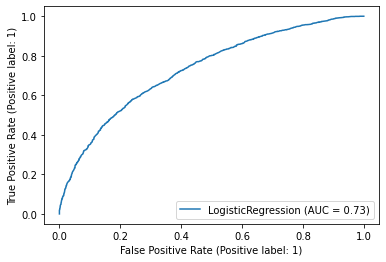

In [50]:
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

Explained variance:
 [0.788, 0.189, 0.016, 0.007, 0.001]


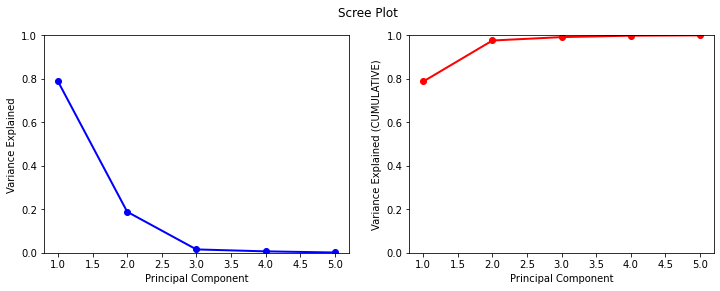

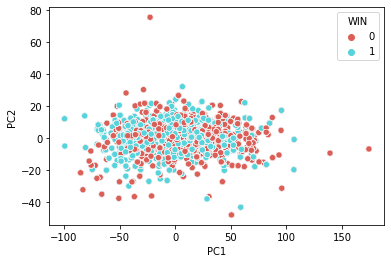

In [51]:
PCA_Model(n_comp=5, df=team_player_df, y_col='WIN', X=X)

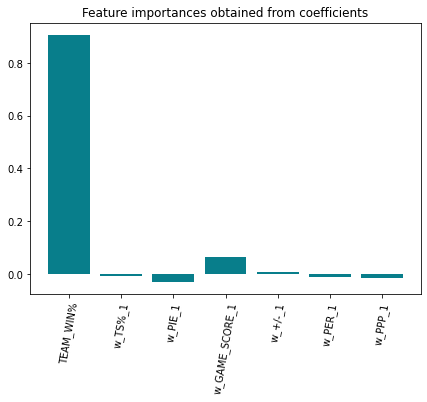

In [52]:
Feature_Importance(logRe, X)

# Individual Talent Ratings: Raptor Metrics (Season) 

In [54]:
raptor_0 = pd.read_csv('modern_RAPTOR_by_team.csv')

raptor_1 = pd.read_csv('latest_RAPTOR_by_team.csv')
raptor = pd.concat([raptor_0, raptor_1])

cols = ['raptor_offense', 'raptor_defense', 'predator_offense', 'predator_defense']
raptor = raptor[raptor.columns[:5].tolist() + cols]
raptor = raptor[raptor['season_type'] == 'RS']
raptor['team'] = raptor['team'].map(lambda x: update_name(x))
raptor.drop(columns = {'player_id', 'season_type'}, inplace = True)
raptor

,player_name,season,team,raptor_offense,raptor_defense,predator_offense,predator_defense
1,Alex Abrines,2017,OKC,0.654933,-0.724233,0.339201,-0.611866
3,Alex Abrines,2018,OKC,-0.211818,-1.728584,-0.482078,-1.172227
4,Alex Abrines,2019,OKC,-4.040157,1.885618,-4.577678,1.543282
6,Precious Achiuwa,2021,MIA,-4.113660,0.709264,-3.657064,0.374133
8,Precious Achiuwa,2022,TOR,-2.516108,2.410593,-2.348484,2.251909
...,...,...,...,...,...,...,...
471,Delon Wright,2023,WAS,-1.047035,13.043916,0.048575,13.891437
472,McKinley Wright IV,2023,DAL,12.934603,9.986798,4.233379,12.245880
473,Thaddeus Young,2023,TOR,-0.811055,1.097810,-0.814821,1.951093
474,Trae Young,2023,ATL,6.212981,-2.086393,6.237908,-2.981636


In [55]:
def nba_season(YM):
    year = YM[:4]
    month = YM[-2:]
    if month < '10': 
        return int(year)
    else:
        return int(year) + 1

avg_df['SEASON'] = avg_df['YM'].map(lambda x: nba_season(x))

In [56]:
raptor_merged = pd.merge(avg_df, raptor, left_on = ['SEASON', 'PLAYER', 'TEAM'], right_on = ['season', 'player_name', 'team'])

team_player_df = raptor_merged.groupby(['TEAM','YM'])[['PLAYER_WIN%','TEAM_WIN%','w_PIE_1','w_GAME_SCORE_1',\
'w_+/-_1', 'w_PER_1', 'w_TS%_1', 'w_PPP_1', \
'raptor_offense', 'raptor_defense','predator_offense', 'predator_defense']].agg({\
'PLAYER_WIN%':'mean', 'TEAM_WIN%':'mean', 'w_TS%_1' : 'mean', 'w_PIE_1': 'sum', 'w_GAME_SCORE_1':'sum',\
'w_+/-_1':'sum','w_PER_1':'sum', 'w_PPP_1':'sum', 'raptor_offense': 'mean',\
'raptor_defense': 'mean', 'predator_offense': 'mean', 'predator_defense': 'mean'}).reset_index()

In [57]:
counter_df = avg_df.groupby(['TEAM', 'YM', 'GAME_ID'])[['WIN']].max().reset_index()

team_player_df = pd.merge(counter_df, team_player_df, on = ['TEAM', 'YM'], how = 'left')
team_player_df.dropna(inplace = True)

In [58]:
team_player_df

,TEAM,YM,GAME_ID,WIN,PLAYER_WIN%,TEAM_WIN%,w_TS%_1,w_PIE_1,w_GAME_SCORE_1,w_+/-_1,w_PER_1,w_PPP_1,raptor_offense,raptor_defense,predator_offense,predator_defense
0,ATL,2015/11,21500039,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972,-0.722868,0.741042,-0.468062,0.724574
1,ATL,2015/11,21500055,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972,-0.722868,0.741042,-0.468062,0.724574
2,ATL,2015/11,21500062,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972,-0.722868,0.741042,-0.468062,0.724574
3,ATL,2015/11,21500081,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972,-0.722868,0.741042,-0.468062,0.724574
4,ATL,2015/11,21500086,1,0.742500,0.588235,4.049770,129.715994,121.722757,11.239570,187.180468,12.287972,-0.722868,0.741042,-0.468062,0.724574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17145,WAS,2022/11,22200265,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934,-1.629406,-0.356477,-1.241178,-0.609956
17146,WAS,2022/11,22200277,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934,-1.629406,-0.356477,-1.241178,-0.609956
17147,WAS,2022/11,22200294,0,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934,-1.629406,-0.356477,-1.241178,-0.609956
17148,WAS,2022/11,22200300,1,0.684783,0.533333,4.709075,120.891165,103.602940,18.884429,178.169739,12.121934,-1.629406,-0.356477,-1.241178,-0.609956


In [59]:
X = team_player_df.iloc[:, 4:]
y = team_player_df['WIN']

x = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

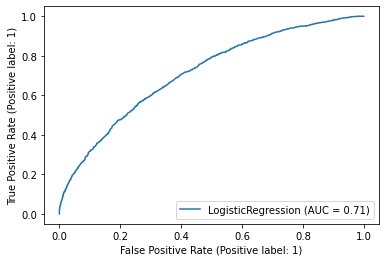

In [60]:
logRe = LogisticRegression().fit(X_train, y_train)
y_pred = logRe.predict(X_test)
plot_roc_curve(logRe, X_test, y_test)

Explained variance:
 [0.791, 0.186, 0.016, 0.007, 0.0]


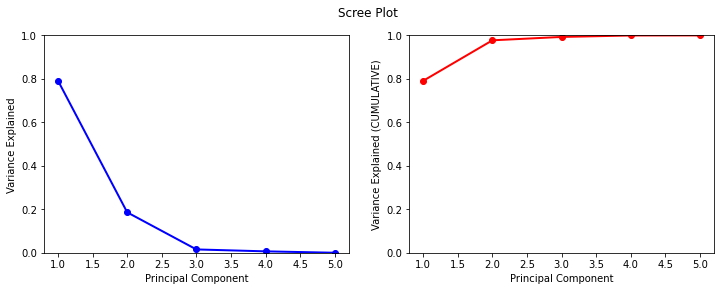

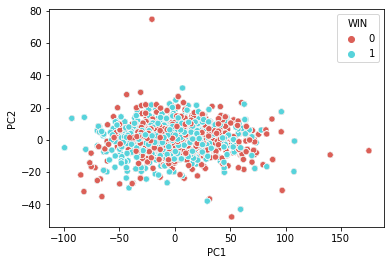

In [61]:
PCA_Model(n_comp=5, df=team_player_df, y_col='WIN', X=X)

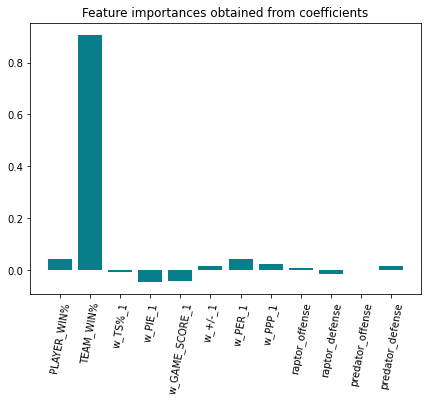

In [62]:
Feature_Importance(logRe, X)